#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [2]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

In [3]:
data = pd.read_csv('/datasets/taxi.csv') 

In [4]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

## Анализ

Чтобы проверить, в хронологическом ли порядке расположены даты и время, посмотрим атрибут индекса таблицы **is_monotonic**

In [6]:
data.sort_index(inplace = True)
data.index.is_monotonic

True

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


### Ресемплирование

In [8]:
data = data.resample('1H').sum()

### Тренд

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


Визуализируем тренд, сезонность и остатки.

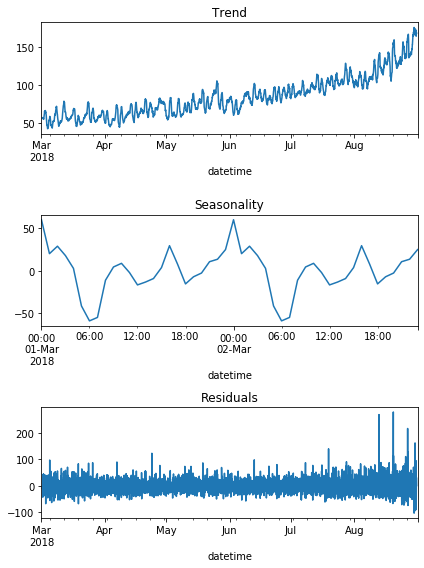

In [11]:
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдается четкий тренд на рост общего числа заказов

Пиковый спрос наблюдается в районе полуночи, меньше всего заказов ближе к 6 утра.

## Обучение

### Результирующий датафрейм

In [12]:
results = pd.DataFrame(columns = ['test_score'])

### Функция для создания признаков в датафрейме

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    new_data = data.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = new_data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return new_data

### Разбивка датасета на обучающаю и тестовую выборки

In [14]:
new_data = make_features(data, 72, 10) # разность временного ряда - 3 дня

train, test = train_test_split(new_data, shuffle=False, test_size=0.1)
train = train.dropna() 

In [15]:
train_X = train.drop(columns = 'num_orders')
train_Y = train['num_orders']
test_X = test.drop(columns = 'num_orders')
test_Y = test['num_orders']

Создадим датафрейм для записи предсказаний моделей

In [16]:
results_pred = pd.DataFrame()
results_pred['y_true'] = test_Y

### Обучение модели LinearRegression

In [17]:
reg = LinearRegression();
reg.fit(train_X, train_Y)
test_pred = reg.predict(test_X)

test_score = mean_squared_error(test_Y,test_pred)**0.5
test_score

42.4734078635134

In [18]:
results.loc['lr'] = test_score
results_pred['lr'] = test_pred

In [19]:
print(7)

7


### Обучение модели lightgbm

In [20]:
lgbm = LGBMRegressor (max_depth = 6, n_estimators = 800)

In [21]:
lgbm.fit(train_X, train_Y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=6,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=800, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [22]:
predictions = lgbm.predict(test_X)

In [23]:
test_score = mean_squared_error(test_Y, predictions)**0.5
test_score

38.88452593091616

In [24]:
results.loc['lgbm'] = test_score
results_pred['lgbm'] = predictions

### Обучение модели DecisionTreeRegressor

Создадим функцию для расчета RMSE

In [25]:
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5
rmse_score = make_scorer(rmse, greater_is_better=False)

In [26]:
tree = DecisionTreeRegressor(random_state = 12345)
params = {
    'max_depth' : range(9,15,2)
}

tscv = TimeSeriesSplit(n_splits = 2)
tree_model = RandomizedSearchCV (tree,params, cv=tscv, random_state = 12345,verbose = 2, scoring = rmse_score)

In [27]:
tree_model.fit(train_X,train_Y)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=9, total=   0.1s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=9, total=   0.1s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   0.1s
[CV] max_depth=11 ....................................................
[CV] ..................................... max_depth=11, total=   0.2s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.1s
[CV] max_depth=13 ....................................................
[CV] ..................................... max_depth=13, total=   0.2s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.7s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
                   error_score='raise-deprecating',
                   estimator=DecisionTreeRegressor(criterion='mse',
                                                   max_depth=None,
                                                   max_features=None,
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   presort=False,
                                                   random_state=12345,
                                                   splitter='best'),
               

In [28]:
tree_model.best_params_

{'max_depth': 9}

In [29]:
predictions = tree_model.predict(test_X)

In [30]:
test_score = rmse(test_Y, predictions)
test_score

62.00796327842393

In [31]:
results.loc['tree'] = test_score
results_pred['tree'] = predictions

### Обучение модели RandomForestRegressor

In [32]:
forest = RandomForestRegressor(random_state = 12345)
params = {
    'max_depth' : range(9,15,2),
    'n_estimators' : range (10,51,10)
}
forest_model = RandomizedSearchCV (forest,params, cv=tscv, random_state = 12345,verbose = 2,scoring = rmse_score)

In [33]:
forest_model.fit(train_X,train_Y)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] n_estimators=10, max_depth=9 ....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ..................... n_estimators=10, max_depth=9, total=   0.4s
[CV] n_estimators=10, max_depth=9 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ..................... n_estimators=10, max_depth=9, total=   0.8s
[CV] n_estimators=20, max_depth=13 ...................................
[CV] .................... n_estimators=20, max_depth=13, total=   1.0s
[CV] n_estimators=20, max_depth=13 ...................................
[CV] .................... n_estimators=20, max_depth=13, total=   2.2s
[CV] n_estimators=30, max_depth=11 ...................................
[CV] .................... n_estimators=30, max_depth=11, total=   1.4s
[CV] n_estimators=30, max_depth=11 ...................................
[CV] .................... n_estimators=30, max_depth=11, total=   2.8s
[CV] n_estimators=40, max_depth=11 ...................................
[CV] .................... n_estimators=40, max_depth=11, total=   1.9s
[CV] n_estimators=40, max_depth=11 ...................................
[CV] .................... n_estimators=40, max_depth=11, total=   3.8s
[CV] n_estimators=40, max_depth=9 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   43.0s finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=2),
                   error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,

In [34]:
predictions = forest_model.predict(test_X)
test_score = rmse(test_Y, predictions)
test_score

40.488406111057714

In [35]:
results.loc['forest'] = test_score
results_pred['forest'] = predictions

## Тестирование

In [36]:
results

,test_score
lr,42.473408
lgbm,38.884526
tree,62.007963
forest,40.488406


Визуализируем предсказания

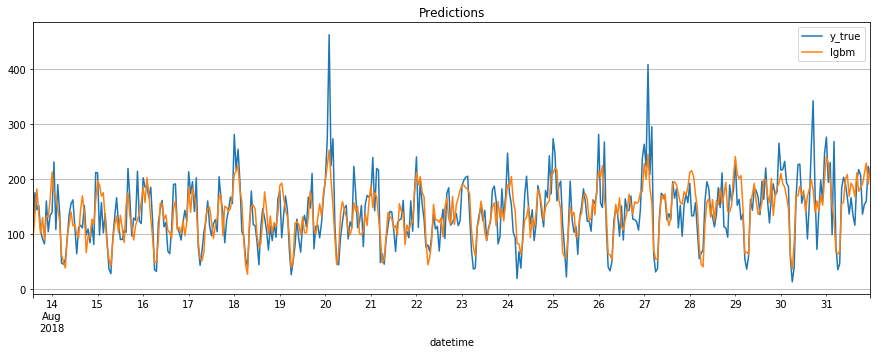

In [42]:
results_pred.plot(y = ['y_true','lgbm'],figsize = (15,5), grid = True, title = 'Predictions')

### Вывод

Из рассмотренных моделей только DecisionTreeRegressor не смогла показать результат ниже 48. Параметры, используемые для обработки исходного датасета:

- разность временного ряда - 3 дня
- размер окна скользящего среднего - 10